In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from os import mkdir
from os.path import basename, join, isfile, isdir

In [2]:
conditions = ['go', 'failed stop', 'junk', 'successful stop']
fix_len = 0.5  # Fixation ring on screen for 500ms before arrow appears

data_dir = '/scratch/PSB6351_2017/ds008_R2.0.0/'
ev_dir = '/scratch/PSB6351_2017/students/salo/data/'
subjects = [basename(s) for s in glob(join(data_dir, 'sub-*'))]
ISIs = np.array([])
for s in subjects:
    tsvs = sorted(glob(join(data_dir, s, 'func/{0}_task-stopsignal_run-*_events.tsv'.format(s))))
    for tsv in tsvs:
        run_name = re.search('(run-[0-9][0-9])', tsv).group(0)
        func_file = join(data_dir, s, 'func/{0}_task-stopsignal_{1}_bold.nii.gz'.format(s, run_name))
        if not isfile(func_file):
            print('{0} {1} functional data DNE.'.format(s, run_name))
        else:
            df = pd.read_csv(tsv, sep='\t')
            df['good_trials'] = pd.to_numeric(df['duration'], errors='coerce')
            df.dropna(subset=['good_trials'], inplace=True)
            df['trial_length'] = df['response_time'].astype(float) + fix_len
            idx = df['response_time']==0.
            df.loc[idx, 'trial_length'] = df.loc[idx, 'duration'].astype(float)
            ITIs = np.diff(df['onset'])
            trial_lengths = df['trial_length'].values
            ISIs = np.concatenate((ISIs, ITIs-trial_lengths[:len(ITIs)]))
            for c in conditions:
                c_name = c.replace(' ', '_')
                red_df = df.loc[df['trial_type']==c]
                
                if red_df.shape[0]>0:
                    # Extract relevant fields from red_df, use RT as amplitude
                    rt_amp = red_df[['onset', 'duration', 'trial_length']].values.astype(float)
                    rt_dur = red_df[['onset', 'trial_length']].values.astype(float)
                    rt_dur = np.concatenate((rt_dur, np.ones((rt_dur.shape[0], 1))), axis=1)

                    # Mean center parametric modulator to 1
                    rt_amp[:, -1] = rt_amp[:, -1] - (np.mean(rt_amp[:, -1]) - 1)

                    # Write out EV files
                    if not isdir(join(ev_dir, 'EVs_RTamp/{0}/'.format(s))):
                        mkdir(join(ev_dir, 'EVs_RTamp/{0}/'.format(s)))
                    
                    if not isdir(join(ev_dir, 'EVs_RTdur/{0}/'.format(s))):
                        mkdir(join(ev_dir, 'EVs_RTdur/{0}/'.format(s)))
                    
                    rt_amp_name = 'EVs_RTamp/{0}/{1}.{2}.txt'.format(s, c_name, run_name)
                    np.savetxt(join(ev_dir, rt_amp_name), rt_amp, delimiter='\t', fmt='%.4f')

                    rt_dur_name = 'EVs_RTdur/{0}/{1}.{2}.txt'.format(s, c_name, run_name)
                    np.savetxt(join(ev_dir, rt_dur_name), rt_dur, delimiter='\t', fmt='%.4f')

sub-11 run-03 functional data DNE.
sub-12 run-03 functional data DNE.


/home/data/nbc/ns-vs-bm/ns-vs-bm/env/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Mean ISI is 1.81923692004


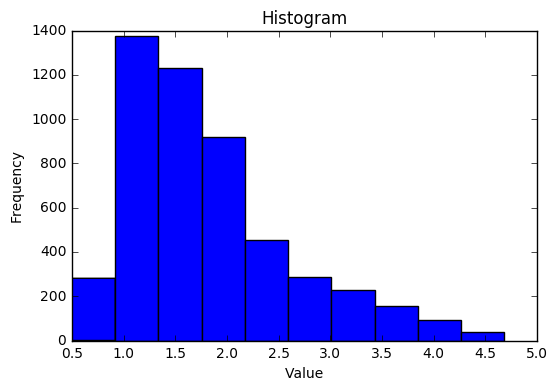

In [3]:
fig, ax = plt.subplots()
ax.hist(ISIs)
ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
fig.show()
print('Mean ISI is {0}'.format(np.mean(ISIs)))